# 

# P5 - Convolutioneel neuraal netwerk

###### Door Peter Kemner, 1806201.

In dit notebook ga ik een convoltioneel neuraal netwerk maken om kleuren plaatjes te classificeren van de CIFAR-10 dataset. Deze notebook is het eerste deel van de opdracht waarbij het netwerk is gemaakt zonder aanvullende technieken.

# Opzet notebook

Het notebook heeft de volgende opzet:
- Data formatting,
- Maken CNN,
- Overplotting,
- Training en resultaten.

# Data formatting

Ik begin met de data voorbereiden voor het model,

In [118]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Activation, Dense
from tensorflow.keras.optimizers import SGD, Adam, schedules
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [119]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("x_test shape", x_test.shape)
print("y_test shape", y_test.shape)

x_train shape (50000, 32, 32, 3)
y_train shape (50000, 1)
x_test shape (10000, 32, 32, 3)
y_test shape (10000, 1)


In [120]:
X_train = x_train.reshape(50000, 32, 32, 3)
X_test = x_test.reshape(10000, 32, 32, 3)

X_train = X_train.astype('float32')         
X_test = X_test.astype('float32')

X_train /= 255                              
X_test /= 255

In [121]:
nb_classes = 10

Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

print(f"Y_train: {Y_train.shape}, Y_test: {Y_test.shape}")

Y_train: (50000, 10), Y_test: (10000, 10)


In [122]:
def plot_images(x, X, y):
    # Define number of rows & columns
    num_row = 2
    num_col = 8
    num = num_row * num_col
    
    # Plot before
    print('BEFORE:\n')
    fig1, axes1 = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
    for i in range(num):
        ax = axes1[i // num_col, i % num_col]
        ax.imshow(x[i])
        ax.set_title('Label: {}'.format(y[i]))
        ax.axis('off')
    plt.show()
    
    # Plot after
    print('AFTER:\n')
    fig2, axes2 = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
    for X_aug, Y_aug in datagen.flow(X, y, batch_size=num, shuffle=False):
        for i in range(0, num):
            ax = axes2[i // num_col, i % num_col]
            ax.imshow(X_aug[i])
            ax.set_title('Label: {}'.format(int(Y_aug[i])))
            ax.axis('off')
        break
    plt.show()

BEFORE:



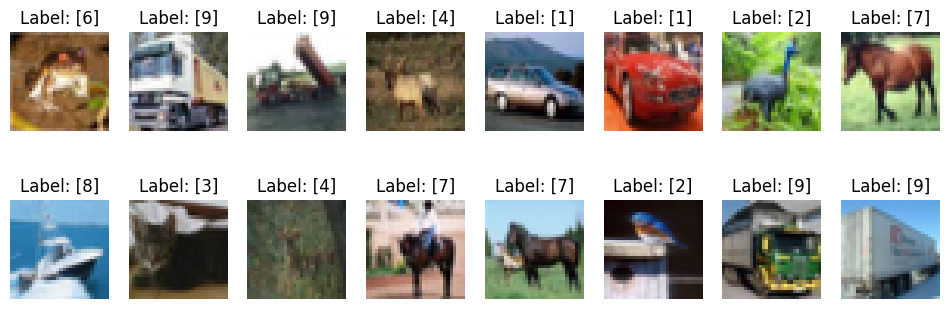

AFTER:



C:\Users\peter\AppData\Local\Temp\ipykernel_8648\2622081334.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title('Label: {}'.format(int(Y_aug[i])))


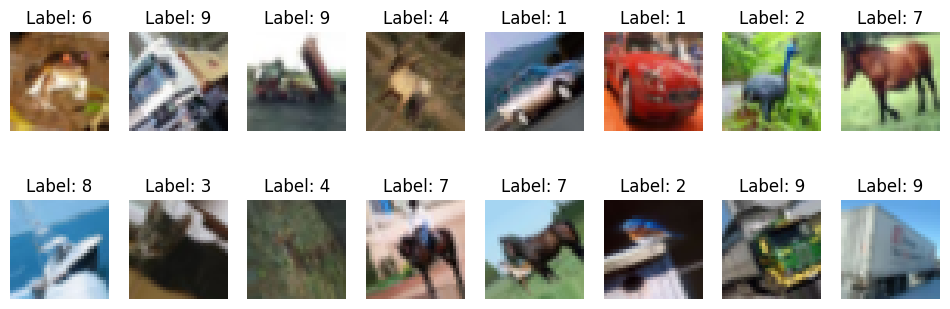

In [123]:
datagen = ImageDataGenerator(rotation_range=40)
datagen.fit(X_train)

plot_images(x_train, X_train, y_train)

BEFORE:



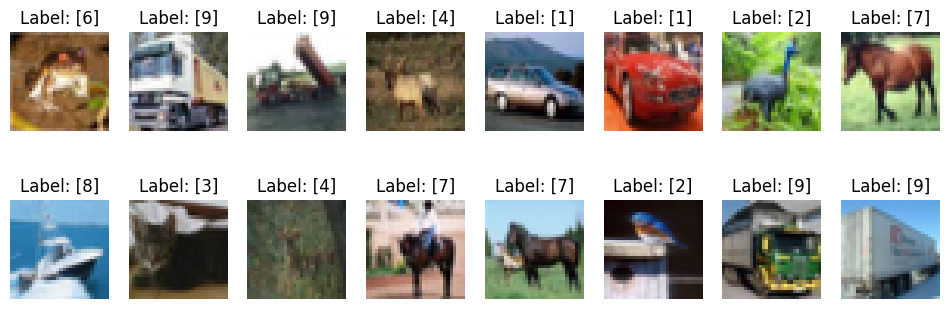

AFTER:



C:\Users\peter\AppData\Local\Temp\ipykernel_8648\2622081334.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title('Label: {}'.format(int(Y_aug[i])))


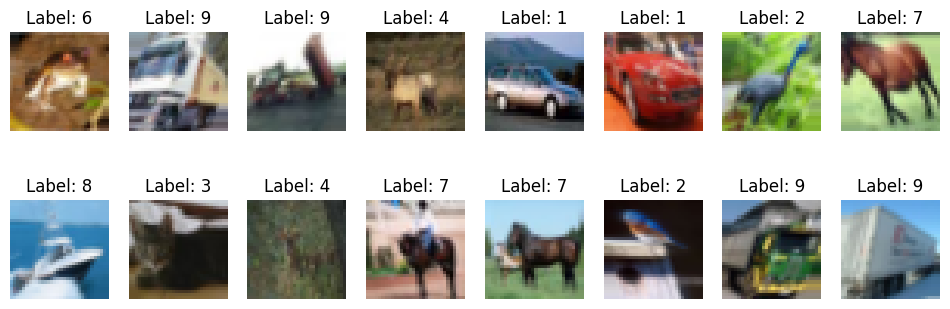

In [124]:
datagen = ImageDataGenerator(shear_range=20)
datagen.fit(X_train)

plot_images(x_train, X_train, y_train)

In [125]:
new_data = ImageDataGenerator(rotation_range=40, shear_range=20)
datagen.fit(X_test)

X_test_augmented, Y_test_augmented = next(datagen.flow(X_test, Y_test, batch_size=X_test.shape[0], shuffle=False))

In [126]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3)))
model.add(Activation('relu') )

model.add(Conv2D(filters=32, kernel_size=(3, 3)))
model.add(Activation('relu') )

model.add(Conv2D(filters=32, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(Conv2D(filters=64, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3)))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(500))
model.add(Activation('relu'))

model.add(Dense(300))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [127]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 activation_117 (Activation  (None, 30, 30, 32)        0         
 )                                                               
                                                                 
 conv2d_79 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 activation_118 (Activation  (None, 28, 28, 32)        0         
 )                                                               
                                                                 
 conv2d_80 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 activation_119 (Activation  (None, 26, 26, 32)      

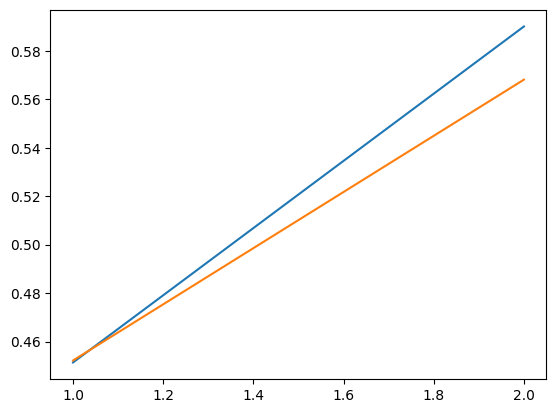

In [128]:
def plot_overfitting(max_epochs, model):
    initial_weights = model.get_weights()
    train_acc = []
    test_acc = []
    for epoch in range(1, max_epochs + 1):
        model.fit(X_train, Y_train, batch_size = 128, epochs=epoch, verbose=0, validation_split = 0.2, validation_steps=12000//128)
        _, accuracy1 = model.evaluate(X_train, Y_train, verbose=0)
        _, accuracy2 = model.evaluate(X_test, Y_test, verbose=0)
        train_acc.append(accuracy1)
        test_acc.append(accuracy2)
    # return [accuracy1, accuracy2]
    
    plt.plot(range(1, max_epochs + 1), train_acc, label='Training Accuracy')
    plt.plot(range(1, max_epochs + 1), test_acc, label='Testing Accuracy')
    plt.show()
    model.set_weights(initial_weights)

plot_overfitting(2, model)

# train_acc = []
# test_acc = []
# max_epochs = 2

# for x in range(1, max_epochs + 1):
#     train_acc.append(plot_overfitting(x)[0])
#     test_acc.append(plot_overfitting(x)[1])

# plt.plot(range(1, max_epochs + 1), train_acc, label='Training Accuracy')
# plt.plot(range(1, max_epochs + 1), test_acc, label='Testing Accuracy')
# plt.show()

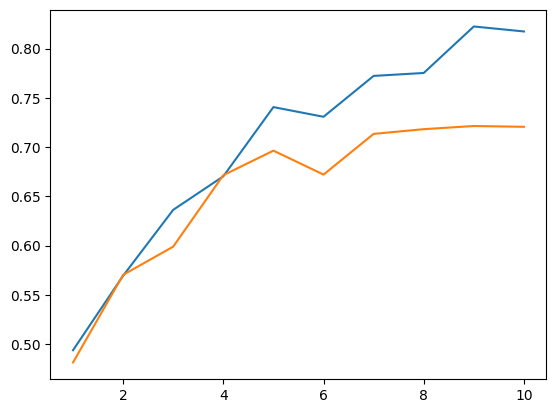

In [129]:
model.fit(X_train, Y_train, batch_size = 128, epochs=4, verbose=1, validation_split = 0.2, validation_steps=12000//128)

Epoch 1/4
313/313 [==============================] - 20s 64ms/step - loss: 1.9626 - accuracy: 0.2595 - val_loss: 1.6913 - val_accuracy: 0.3748
Epoch 2/4
313/313 [==============================] - 18s 58ms/step - loss: 1.5103 - accuracy: 0.4442
Epoch 3/4
313/313 [==============================] - 18s 58ms/step - loss: 1.2744 - accuracy: 0.5401
Epoch 4/4
313/313 [==============================] - 19s 59ms/step - loss: 1.1323 - accuracy: 0.5949


In [130]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

313/313 [==============================] - 2s 6ms/step - loss: 1.0968 - accuracy: 0.6048
Test loss: 1.0968
Test accuracy: 0.6048


In [131]:
datagen.fit(X_test)
X_test_augmented, Y_test_augmented = next(datagen.flow(X_test, Y_test, batch_size=10_000))

In [132]:
loss, accuracy = model.evaluate(X_test_augmented, Y_test_augmented)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

313/313 [==============================] - 2s 6ms/step - loss: 1.2543 - accuracy: 0.5492
Test loss: 1.2543
Test accuracy: 0.5492
